In [1]:
import pandas as pd
import numpy as np
from nlp_functions import preprocess,plot_top_10_words_from_count,print_topics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF


property_type = 'townhouse'
df = pd.read_csv('./data/' + 'Boston_%s_remarks.csv'%property_type,index_col=0)

print(df['REMARKS'].iloc[0])

df_processed = df['REMARKS'].apply(lambda x: preprocess(x,pos_tag=['NNP','VBP']))

print(' ')
print(df_processed.iloc[0])





ModuleNotFoundError: No module named 'nlp_functions'

In [79]:
ngram = 1
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   analyzer='word',
                                   strip_accents='ascii',
                                   ngram_range=(ngram,ngram))

corpus_tfidf = tfidf_vectorizer.fit_transform(df_processed.astype(str))

n_topic = 10

nmf = NMF(n_components=n_topic, random_state=101).fit(corpus_tfidf)
nmf.fit(corpus_tfidf)

n_top_words = 10
print_topics(nmf, tfidf_vectorizer, n_top_words)

Topic #0: room, live, din, level, bedroom, famili, kitchen, space, size, fireplac
Topic #1: thi, home, opportun, properti, offer, famili, singl, sell, buyer, need
Topic #2: new, brand, roof, electr, water, renov, heat, hot, plumb, heater
Topic #3: level, suit, master, closet, bath, custom, privat, featur, ga, deck
Topic #4: lead, room, builtin, window, door, wood, fireplac, glass, origin, foyer
Topic #5: stainless, applianc, steel, bathroom, light, granit, featur, renov, countertop, counter
Topic #6: floor, bath, bedroom, second, larg, room, hardwood, half, plan, area
Topic #7: street, updat, walk, commut, park, rail, distanc, bu, quiet, yard
Topic #8: lot, squar, feet, includ, garag, potenti, foot, corner, attach, zone
Topic #9: transport, public, shop, locat, close, park, school, restaur, access, space


In [74]:
words = np.array(tfidf_vectorizer.get_feature_names())

topic_word_vectors = []
for i in range(n_topic):
    topic_word_vectors.append(words[nmf.components_[i].argsort()[:-n_top_words - 1:-1]])

    
def topic_similarity(remark):
    return [len(set(remark.split(' ')).intersection(set(topic_word_vectors[i])))/n_top_words
            for i in range(n_topic)]

df_topic_vector = df_processed.apply(topic_similarity)

print(df_topic_vector)



2       [0.6, 0.6, 0.4, 0.5, 0.0, 0.3, 0.4, 0.5, 0.5, ...
5       [0.8, 0.1, 0.1, 0.7, 0.1, 0.8, 0.7, 0.3, 0.5, ...
9       [0.8, 0.1, 0.3, 0.7, 0.2, 0.1, 0.2, 0.4, 0.2, ...
11      [0.4, 0.4, 0.4, 0.2, 0.3, 0.1, 0.5, 0.5, 0.4, ...
12      [0.7, 0.2, 0.1, 0.4, 0.3, 0.2, 0.6, 0.2, 0.4, ...
                              ...                        
9970    [0.4, 0.0, 0.2, 0.1, 0.2, 0.0, 0.3, 0.1, 0.0, ...
9982    [0.0, 0.2, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9984    [0.2, 0.4, 0.2, 0.5, 0.0, 0.1, 0.1, 0.1, 0.5, ...
9997    [0.3, 0.6, 0.0, 0.5, 0.1, 0.3, 0.3, 0.1, 0.5, ...
9998    [0.8, 0.1, 0.1, 0.4, 0.4, 0.3, 0.6, 0.4, 0.3, ...
Name: REMARKS, Length: 1480, dtype: object


(1479, 10)


<IPython.core.display.Javascript object>


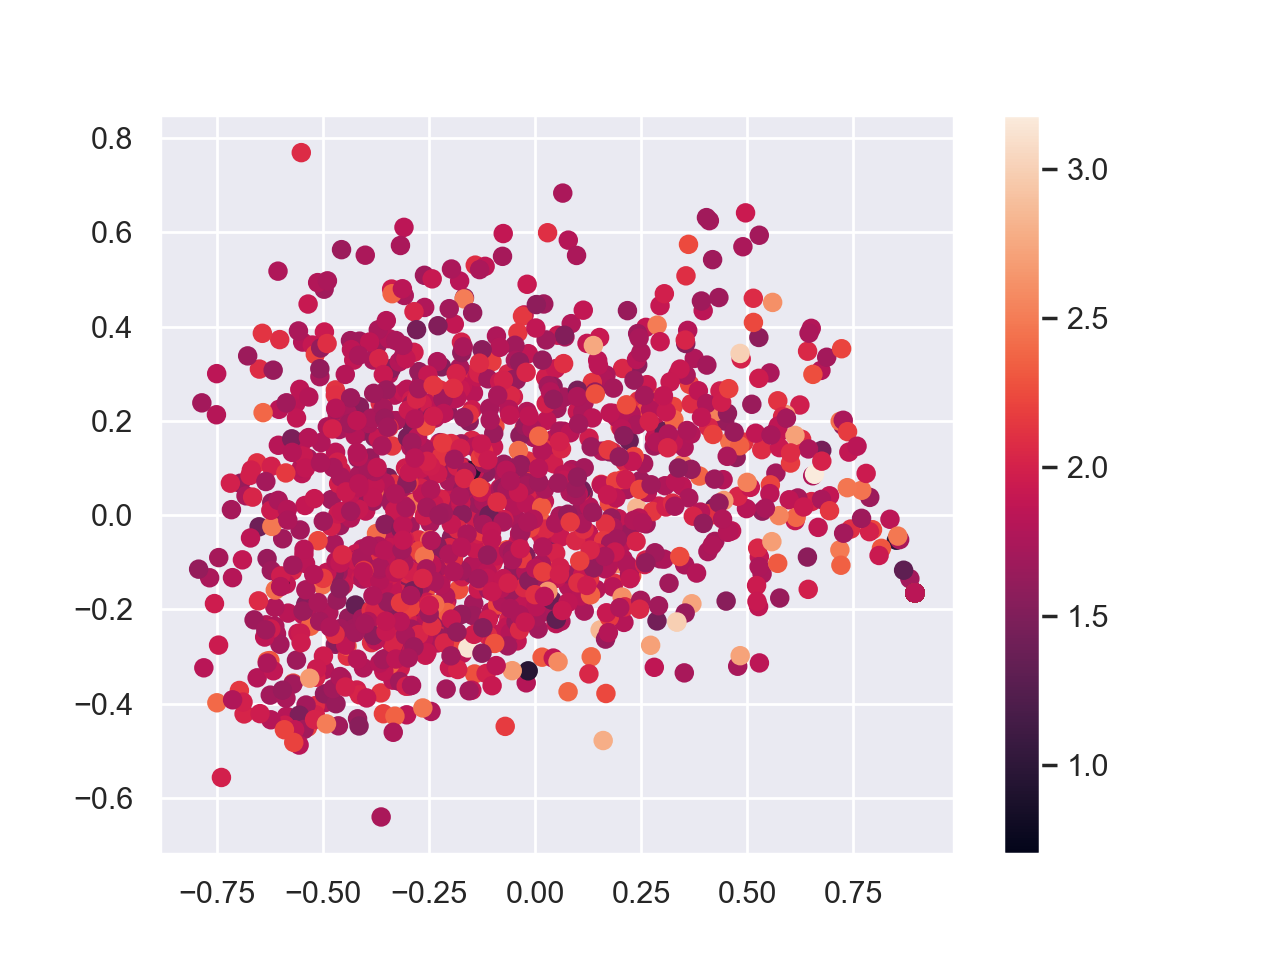

In [77]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

sns.set()

df_master = pd.read_csv('./data/' + 'redfin_2020-01-19-08-17-26.csv')
df_transaction = pd.read_csv('./data/' + 'Boston_%s_transaction.csv'%property_type,index_col=0)

df_regr = df_master[['$/SQUARE FEET','YEAR BUILT']].join(df_topic_vector,how='inner')
df_regr = df_regr.join(df_transaction,how='inner')

df_regr['LIST DATE'] = pd.to_datetime(df_regr['LIST DATE'])
df_regr['SOLD DATE'] = pd.to_datetime(df_regr['SOLD DATE'])

df_regr['DAYS ON MKT'] = (df_regr['SOLD DATE'] - df_regr['LIST DATE']).apply(lambda x: x.days)

mask1 = df_regr['DAYS ON MKT'] > 0 # price history scraped after spreadsheet
mask2 = df_regr['LIST PRICE'] < 1e8 # one typo with list price = 1.6e8
mask = np.logical_and(mask1,mask2)

df_regr = df_regr[mask]

X = []
for i in range(len(df_regr)):
    X.append(df_regr['REMARKS'].iloc[i])
    
print(np.asarray(X).shape)

pca = PCA(n_components=2)
X_emb = pca.fit_transform(X)


fig = plt.figure()
plt.scatter(X_emb[:,0],X_emb[:,1],c=np.log10(df_regr['DAYS ON MKT'].values))
plt.colorbar()
plt.show()
